In [1]:
from datetime import datetime
import logging
import json
import os
import uuid
import time
from uuid import uuid4
import shutil


# from langchain_elasticsearch import ElasticsearchStore
from werkzeug.utils import secure_filename
import tempfile

from langchain_community.embeddings import HuggingFaceEmbeddings
# from langchain.embeddings import SentenceTransformerEmbeddings
from langchain_elasticsearch import ElasticsearchStore
# from langchain_core.documents import Document

from unstructured.partition.pdf import partition_pdf
# from services.sql_connection import sql_connect
# import sqlite3

# from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_core.documents import Document
from unstructured.partition.docx import partition_docx

d:\30. Open Source llm -RAG\Knowledge-Hub-Assistant\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def document_retrieval_chunking(file_path):
	try:
		if file_path.endswith(".pdf"):
			print("--------------PDF FILE DETECTED-------------")
			chunks = partition_pdf(
				filename=file_path,
				infer_table_structure=True,  # extract tables
				strategy="hi_res",  # mandatory to infer tables
				extract_image_block_types=[
					"Image"
				],  # Add 'Table' to list to extract image of tables
				# image_output_dir_path=output_path,  # if None, images and tables will saved in base64
				extract_image_block_to_payload=True,  # if true, will extract base64 for API usage
				chunking_strategy="by_title",  # or 'basic', by_page - api
				max_characters=10000,  # defaults to 500
				combine_text_under_n_chars=2000,  # defaults to 0
				new_after_n_chars=6000,
				# extract_images_in_pdf=True,          # deprecated
			)
			print(chunks)
			return chunks
		elif file_path.endswith(".docx"):
			print("--------------DOCX FILE DETECTED-------------")
			chunks = partition_docx(filename=file_path,
                        strategy="hi_res",
                        infer_table_structure=True, 
                        include_page_breaks=True,
                        extract_image_block_types=["Image"], 
                        extract_image_block_to_payload=True,
                        chunking_strategy="by_title",
                        max_characters=10000,
                        combine_text_under_n_chars=2000,  # defaults to 0
                        new_after_n_chars=6000)
			print(chunks)
			return chunks
	except Exception as e:
		print("partition error ::",e)

In [3]:
def chunk_processing(chunks,file_name,domain):
	list1=[]
	chunk_ids=[]
	for id, chunk in enumerate(chunks):
		chunk_dict = chunk.to_dict()
		elements = chunk.metadata.orig_elements
		chunk_images = [el.to_dict() for el in elements if "Image" in str(type(el))]
		# Preparing the Chunk 
		item = {}

		if "metadata" not in item.keys():
			item['metadata']={}

		# Check the table is in the chunk, is yes add into the text context
		if "Table" in str(elements):
			item["page_content"] = (
				chunk_dict["text"]
				+ "Table in Html format :"
				+ chunk_dict["metadata"]["text_as_html"]
			)
		else:
			item["page_content"] = chunk_dict["text"]

		# Assigning the chunk ids to document chunk
		item["metadata"]["chunk_id"] = file_name + f"_{id}"
		chunk_ids.append(item["metadata"]["chunk_id"])
		# File Metadata
		item["metadata"]["filename"] = chunk_dict["metadata"]["filename"]
		item["metadata"]["element_id"] = chunk_dict["element_id"]
		item["metadata"]['domain']=domain
			
		if "page_number" in chunk_dict["metadata"].keys():
			item["metadata"]["page_number"] = str(chunk_dict["metadata"]["page_number"])
		else:
			item["metadata"]["page_number"] = "NA"
		
		if chunk_images:
			item["metadata"]["images_info"] = str(
				[
					{
						"image_associated_text": i["text"],
						"image_base64": i["metadata"]["image_base64"],
						"images_link": "",
					}
					for i in chunk_images
				]
			)
		# item["chunk_vector"] = generate_embeddings_openai(item["chunk"], client)
		list1.append(item)
	document_list=[Document(page_content=doc['page_content'],metadata=doc['metadata']) for doc in list1]
	return document_list,chunk_ids


# search_client=elastic_search_client()
from langchain_community.embeddings import JinaEmbeddings
from numpy import dot
from numpy.linalg import norm
from PIL import Image

# Initialize the model
embeddings = JinaEmbeddings(jina_api_key="jina_2332cca0b8cc401eac7c37b5fb11fbf7pVCt3u2J1pcxQJrm6RY3aJgFHEAw", 
									model_name="jina-clip-v1")

import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS

index = faiss.IndexFlatL2(len(embeddings.embed_query("hello world")))

vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)


def retrieval():
	temp_folder="uploads"
	destination_directory="document"
	if os.path.exists(temp_folder):
		list_files=os.listdir(temp_folder)
		print("No. of Files Detected ::",len(list_files))

	for file_name in list_files:
		print(file_name)
		file_path=temp_folder+f"\{file_name}"
		chunks=document_retrieval_chunking(file_path) # document_list,chunk_ids
		document_list,chunk_ids=chunk_processing(chunks,file_name,"dummay")
		uuids = [str(uuid4()) for _ in range(len(document_list))]
		## Add File Vectors to the elastic search
		vector_store.add_documents(documents=document_list, ids=uuids)
		status=1
	
		source_path = os.path.join(temp_folder, file_name)
		destination_path = os.path.join(destination_directory, file_name)
		shutil.move(source_path, destination_path)
		print(f'Moved: {file_name}')
		print("Document Chunking, Indexing and Uploaded to Elastic Search Succesfully")


In [4]:
retrieval()

No. of Files Detected :: 1
01_Sean-Yang(TrendForce)_NAND-Flash-Market-Outlook.pdf
--------------PDF FILE DETECTED-------------
[<unstructured.documents.elements.CompositeElement object at 0x0000019C73EE9390>, <unstructured.documents.elements.CompositeElement object at 0x0000019C73EE8880>, <unstructured.documents.elements.CompositeElement object at 0x0000019C73EE9090>, <unstructured.documents.elements.CompositeElement object at 0x0000019C73EEA590>, <unstructured.documents.elements.CompositeElement object at 0x0000019C85003010>, <unstructured.documents.elements.CompositeElement object at 0x0000019C84FE3F10>, <unstructured.documents.elements.CompositeElement object at 0x0000019C73EEAF80>, <unstructured.documents.elements.CompositeElement object at 0x0000019C80439C90>, <unstructured.documents.elements.CompositeElement object at 0x0000019C73EEB880>, <unstructured.documents.elements.CompositeElement object at 0x0000019C8043A5C0>, <unstructured.documents.elements.CompositeElement object at 0x

In [5]:
vector_store.save_local("faiss_index")

In [6]:
new_vector_store = FAISS.load_local(
    "faiss_index", embeddings, allow_dangerous_deserialization=True
)

In [7]:
docs = new_vector_store.similarity_search("Supply Dynamics: Limited Growth &Constant Share")

In [60]:
base64_string=eval(docs[1].metadata['images_info'])[6]['image_base64']

In [61]:
# docs[1].metadata

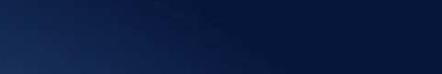

In [62]:
import base64
from IPython.display import display, Image

image_bytes = base64.b64decode(base64_string)

display(Image(data=image_bytes))

In [6]:
from minio import Minio
import pandas as pd
import json
from io import BytesIO
from PIL import Image
import mimetypes

In [15]:
minio_client = Minio(
    "4.240.104.16:9000",  # MinIO server hosted at your URL
    access_key="qjaIb6kmOspGolVOTmYC",
    secret_key="xNb2BC5NJlwc42HYjGyQLMyvfoSnQi7qNXAPtlKE",
    secure=False  # Change to True if using HTTPS
)

In [16]:
# Function to upload any file
def upload_file(bucket_name, object_name, file_path):
    content_type, _ = mimetypes.guess_type(file_path)
    if content_type is None:
        content_type = "application/octet-stream"  # Default content type for unknown files
    
    minio_client.fput_object(bucket_name, object_name, file_path, content_type=content_type)
    print(f"File {object_name} uploaded successfully to {bucket_name} with content type {content_type}")

In [19]:
# Example usage
bucket_name = "documents"

# Upload different types of files
upload_file(bucket_name, "hr_hr_Attention.pdf", "document//01_Sean-Yang(TrendForce)_NAND-Flash-Market-Outlook.pdf")

File hr_hr_Attention.pdf uploaded successfully to documents with content type application/pdf
